In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import utils as u
import itertools
import pandas as pd
import cv2

# 1. Read the image, 
###    assign the wanted rotation
###    plot the original and rotated image

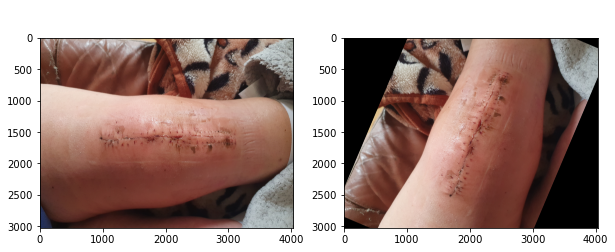

In [3]:
rot_deg=67

root_img_fold = "/home/doga/PycharmProjects/objectLocalization/dataset/wounds/"
a_image_full_path = os.path.join(root_img_fold, "2021-09-01_photo1.jpg")

img = mpimg.imread(a_image_full_path)
img_rot = u.rot_img_cv(img, rot_deg)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title(f"Original image shape {img.shape}", color="white")
ax[1].imshow(img_rot)
ax[1].set_title(f"img_rot rotated by {rot_deg} degrees\nimage shape {img_rot.shape}", color="white")
plt.show()

# 2. Pick a box 
###    now I have img and img_rot
###    define a block to grab and grab it

<Figure size 432x288 with 0 Axes>

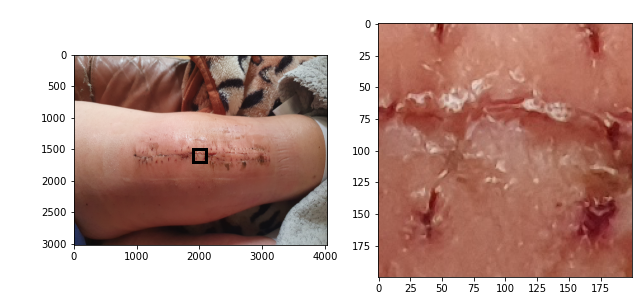

In [4]:
#box_corner = {"col_w":230,"row_h":230}; box_wh = {"w":30,"h":40}
#box_corner = {"col_w":230,"row_h":140}; box_wh = {"w":30,"h":40}
box_corner = {"col_w":1900,"row_h":1500}; box_wh = {"w":200,"h":200}
r = u.get_rectangle((box_corner["col_w"],box_corner["row_h"]), box_wh)
img_box = u.crop_and_show(img, r, figsize=(10, 10), title_color="white")

# 3. Locate the box in original image

In [5]:
coordinate = u.locate_crop(img, img_box, enforce_cpu=False, perc=0.1, max_w=None, verbose=0)
print(f"found coordinates = {coordinate}")
print(f"given coordinates = {box_corner}")

resizing 4032x3024 to 403x302
resizing 200x200 to 20x20
cuda
found coordinates = {'col_w': 1900, 'row_h': 1500}
given coordinates = {'col_w': 1900, 'row_h': 1500}


# 4. Find center of box in rotated image

In [6]:
#find the center of the same block if it is rotated
box_def_rot = None #{"box_corner": box_corner, "box_wh":box_wh}
r_rot, bc_rot, bc_wh_rot = u.find_center_of_box_in_rotated_image(rot_deg, img.shape, 
                                                                 rect_def=r, 
                                                                 verbose=1)

deg(67) = rad(1.1693705988362009)
center_box = [2.0e+03 1.6e+03 1.0e+00]
center_box relative to image center = [-16.  88.   1.]
rot_box - ci = [[74.75272905 49.11241696  1.        ]]
rot_box = [1.99075273e+03 1.46111242e+03 1.00000000e+00]
original rectangle = Rectangle(xy=(1900, 1500), width=200, height=200, angle=0)
bc_rot = {'col_w': 1990, 'row_h': 1461}
bc_wh_rot = {'w': 200, 'h': 200}
rotated rectangle = Rectangle(xy=(1990, 1461), width=200, height=200, angle=0)


# 5. Crop the box from rotated image for search

<Figure size 432x288 with 0 Axes>

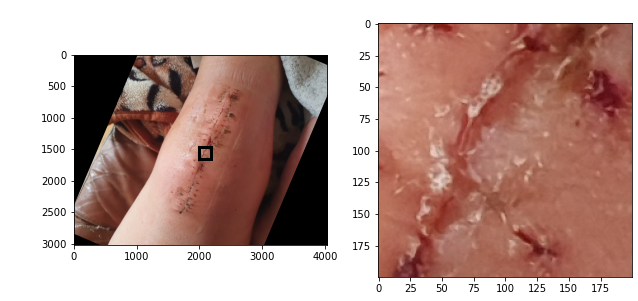

In [7]:
#r_rot = u.get_rectangle((bc_rot["col_w"],bc_rot["row_h"]), bc_wh_rot)
img_box_rot= u.crop_and_show(img_rot, r_rot, figsize=(10, 8), title_color="white")

# 6. Locate the cropped image in rotated images

In [36]:
#%load_ext line_profiler
#from utils import locate_rotated_crop_cosine as lrcc
#%lprun -f  u.locate_rotated_crop_cosine(img, img_box_rot, deg_stride = 5, enforce_cpu=True)
coord_found, cosDistImg = u.locate_rotated_crop_cosine(img, img_box_rot, deg_stride = 2, enforce_cpu=False
                                          ,verbose=2, perc=0.2)
print(f"found coordinates = {coord_found}")
print(f"given coordinates = {bc_rot}")

resizing 4032x3024 to 806x604
resizing 200x200 to 40x40
created image batch of 180 images in 16.908782 seconds
cuda
convolution completed in 28.539752 seconds
cosine_distances calced in 0.000456 seconds
unraveled in 28.006092 seconds
found best match in 0.336049 seconds
foundxy = (398, 292)
remapped_xy = (1990, 1460)
coordinate = (34, 398, 292)
img_crop_activation.shape torch.Size([180, 1, 767, 565])
cosine_distances.shape (180, 767, 565)
rotDegInd(34), rotDeg(68), colWFr(393), colWTo(403), rowHFr(287), rowHTo(297)
cosine_distances_partial
          0         1         2         3         4         5         6  \
0  0.985176  0.985459  0.985899  0.986308  0.986616  0.986900  0.987012   
1  0.985081  0.985769  0.986721  0.987615  0.988199  0.988568  0.988735   
2  0.985213  0.986384  0.987771  0.989178  0.990249  0.990823  0.991036   
3  0.985777  0.987224  0.988997  0.991039  0.992946  0.994092  0.994141   
4  0.986574  0.988146  0.990176  0.992767  0.995790  0.997932  0.997303   
5  0

(767, 565)


/home/doga/anaconda3/envs/objectLocalization/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


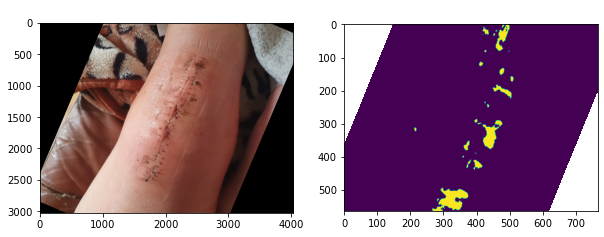

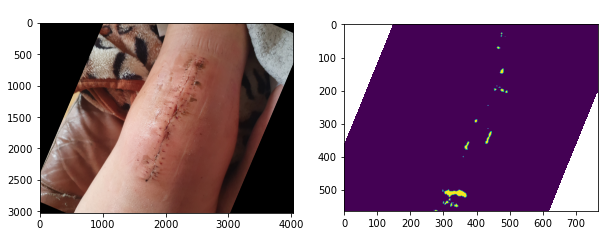

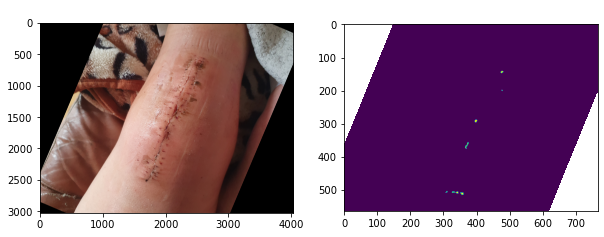

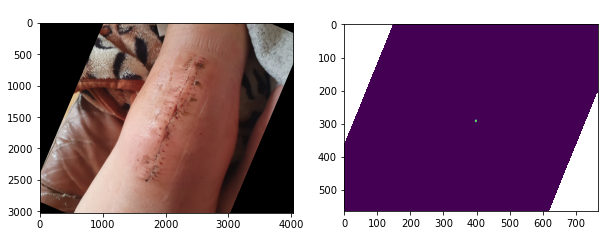

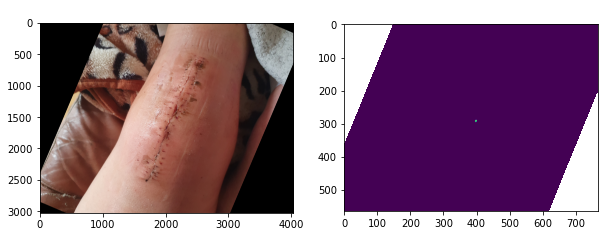

In [43]:
print(cosDistImg.shape)
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_rot)
    ax[0].set_title(f"Original", color="white")
    trsh = 0.988+0.001*i
    c_d = cosDistImg.copy().T
    c_d[c_d<trsh]=0
    ax[1].imshow(c_d)
    ax[1].set_title(f"trsh {trsh}", color="white")
    plt.show()

# 7. Plot the estimated rotation of image and position of block

<Figure size 432x288 with 0 Axes>

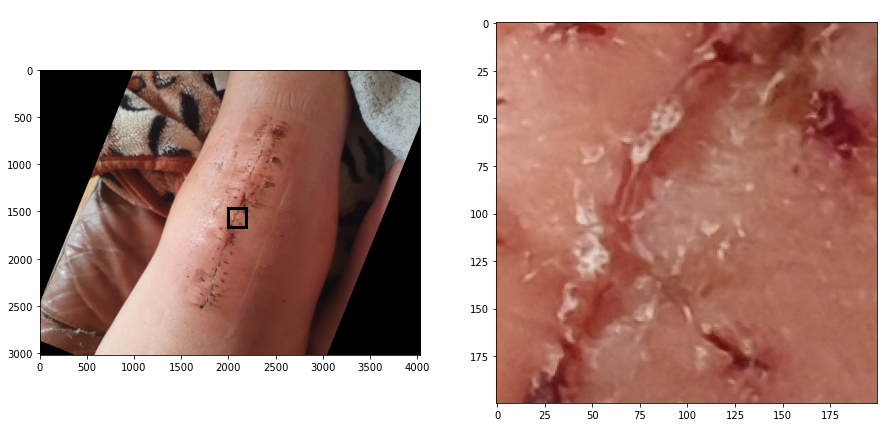

In [44]:
bc_rot_found = {"col_w":coord_found["col_w"],"row_h":coord_found["row_h"]}
r_rot_found = u.get_rectangle((coord_found["col_w"],coord_found["row_h"]), bc_wh_rot)
img_rot_found = u.rot_img_cv(img, coord_found["rot_degree"])
img_box_rot_found = u.crop_and_show(img_rot_found, r_rot_found, figsize=(15, 10), 
                                    title_color="white")

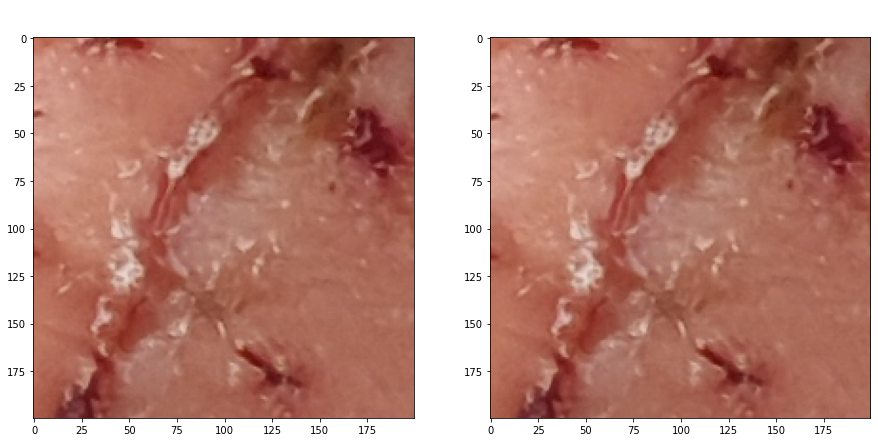

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(img_box_rot)
ax[0].set_title(f"cropped image\n{r_rot}", color="white")
ax[1].imshow(img_box_rot_found)
ax[1].set_title(f"fround crop\n{r_rot_found}", color="white")
plt.show()